# Deliverable 5.1: Offset-Free Tracking with Constant Mass Change

## Objective

Design and test an **offset-free tracking controller** that compensates for model mismatch caused by mass changes.

**Scenario:**
- Design model: mass = 2.0 kg (default from rocket.yaml)
- True system: mass = 1.5 kg (25% lighter - simulates fuel consumption)
- fuel_rate = 0 (mass stays constant during this test)

**Compare:**
1. **Part 4 controller** (no disturbance estimation) → steady-state offset
2. **Part 5 controller** (with disturbance observer) → offset-free tracking

## Test Parameters (as specified in deliverable)

- Initial state: `x0 = [0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1]`
  - Start with velocities: vx=5, vy=5, vz=10 m/s
  - Start at position: [0, 0, 1] m
- Target: Zero velocity `vref = [0, 0, 0]`
- Simulation time: 15 seconds
- Test mass: `rocket.mass = 1.5` kg

## Design Procedure and Tuning

### Problem Formulation

When the actual rocket mass differs from the design mass, the system dynamics are affected by model mismatch. For the Z-velocity channel, we model this as an **additive disturbance**:

$$x^+ = Ax + Bu + B_d d$$

where:
- $x = v_z$ (Z-velocity in deviation coordinates)
- $u$ = thrust input (deviation)
- $d$ = constant unknown disturbance due to mass mismatch
- $B_d = 1$ (disturbance channel)

### Observer Design

We augment the state with the disturbance and design a **Luenberger observer**:

$$\begin{bmatrix} \hat{x}^+ \\ \hat{d}^+ \end{bmatrix} = \begin{bmatrix} A & B_d \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \hat{x} \\ \hat{d} \end{bmatrix} + \begin{bmatrix} B \\ 0 \end{bmatrix} u + L(y - \hat{x})$$

where $y = x$ is the measured velocity.

**Observer gain design:** Pole placement
- State estimation pole: $p_x = 0.30$ (fast convergence)
- Disturbance estimation pole: $p_d = 0.50$ (moderate speed to balance convergence vs noise)

The observer gain $L$ is computed analytically to place these poles.

### MPC Formulation with Disturbance Compensation

The MPC optimization includes the estimated disturbance in the prediction model:

$$\min_{u} \sum_{k=0}^{N-1} \left[ (x_k - r)^T Q (x_k - r) + u_k^T R u_k \right] + (x_N - r)^T P (x_N - r)$$

subject to:
$$\begin{align}
x_{k+1} &= A x_k + B u_k + B_d \hat{d} \\
u_{min} &\leq u_k \leq u_{max}
\end{align}$$

**Tuning parameters:**
- $Q = 100$ (high penalty on velocity tracking error for tight regulation)
- $R = 1$ (moderate penalty on control effort)
- $P$ = solution to discrete-time algebraic Riccati equation (terminal cost)
- Horizon: $N = H/T_s = 5.0/0.05 = 100$ steps
- Input bounds: $u \in [40, 80]\%$ (absolute thrust limits)

### Steady-State Target Computation

For offset-free tracking, we compute the steady-state input that achieves $x_{ss} = r$ given the disturbance estimate:

$$r = A r + B u_{ss} + B_d \hat{d}$$

Solving for $u_{ss}$:

$$u_{ss} = \frac{r - A r - B_d \hat{d}}{B}$$

This ensures that even with disturbance, the controller can track the reference with zero steady-state error.

### Key Design Choices

1. **Z-axis only:** Only the Z-velocity controller has disturbance estimation (most affected by mass)
2. **No terminal set:** Dropped to avoid infeasibility with state estimation
3. **Full state measurement:** We assume we can measure $v_z$ directly (in practice, from IMU)
4. **Disturbance persistence:** We assume $d$ is constant (valid for constant mass)

In [ ]:

# Import Part 4 (NO estimator)
from Deliverable_4_1.LinearMPC.MPCVelControl import MPCVelControl as MPCVelControl_NoEst
from Deliverable_4_1.PIControl.PIControl import PIControl

# Import Part 5 (WITH estimator)
from Deliverable_5_1.LinearMPC_template.MPCVelControl import MPCVelControl

# Use them

from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis, plot_static_states_inputs

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")


ModuleNotFoundError: No module named 'Deliverable_4_1'

## Simulation Parameters

In [ ]:

# Simulation parameters
Ts = 0.05
sim_time =15  # As specified in deliverable
H = 7.0

# Initial state as specified
# [ωx, ωy, ωz, α, β, γ, vx, vy, vz, x, y, z]
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])

# Target: Zero velocity
x_target = np.zeros(12)

# Position target for outer-loop PI (hold current position)
pos_target = np.array([0.0, 0.0, 1.0])

print("Simulation Setup:")
print(f"  Sampling time: {Ts} s")
print(f"  Simulation time: {sim_time} s")
print(f"  MPC horizon: {H} s")
print(f"  Initial velocities: vx={x0[6]}, vy={x0[7]}, vz={x0[8]} m/s")
print(f"  Target velocities: vx=0, vy=0, vz=0 m/s")
print(f"  Position target (PI): {pos_target}")


Simulation Setup:
  Sampling time: 0.05 s
  Simulation time: 15 s
  MPC horizon: 5.0 s
  Initial velocities: vx=5, vy=5, vz=10 m/s
  Target velocities: vx=0, vy=0, vz=0 m/s
  Position target (PI): [0. 0. 1.]


## Part 1: Simulation WITHOUT Estimator (Baseline from Part 4)

This uses your controller from Deliverable 4 which does not have disturbance estimation.

**Expected:** Steady-state velocity offset due to model mismatch.

In [ ]:
print("=" * 70)
print("SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)")
print("=" * 70)

# Create rocket with mass change
rocket_no_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

mpc_no_est = MPCVelControl_NoEst().new_controller(rocket_no_est, Ts, H)

print(f"\nController designed for mass: {float(rocket_no_est.mass):.1f} kg")  

# Change mass to create model mismatch
rocket_no_est.mass = 1.5
rocket_no_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_no_est.mass):.1f} kg")  
print(f"Model mismatch: {(float(rocket_no_est.mass) - 1.0) / 1.0 * 100:.1f}%\n")  

# Simulate
print("Running simulation...")
t_no_est, x_no_est, u_no_est, _, _, _, ref_no_est = rocket_no_est.simulate_control(
    mpc_no_est, sim_time, H, x0, 
    x_target=x_target, 
    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_no_est)} steps)")

# Check steady-state error
print("\nFinal velocities (last 1 second average):")
final_idx = int(-1.0 / Ts)  # Last 1 second
vx_final = np.mean(x_no_est[6, final_idx:])
vy_final = np.mean(x_no_est[7, final_idx:])
vz_final = np.mean(x_no_est[8, final_idx:])

print(f"  vx: {vx_final:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final:.4f} m/s (target: 0.000)")
print(f"\n  → Steady-state offset magnitude: {np.linalg.norm([vx_final, vy_final, vz_final]):.4f} m/s")

SIMULATION WITHOUT ESTIMATOR (Part 4 Controller)

Controller designed for mass: 2.0 kg
Actual system mass: 1.5 kg
Model mismatch: 50.0%

Running simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.21 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.65: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
 State beta violation: -0.17 < -0.17, 
 St

## Part 2: Simulation WITH Estimator (Part 5 Controller)

This uses your enhanced controller from Deliverable 5 with disturbance estimation.

**Expected:** Offset-free tracking despite model mismatch.

In [ ]:
print("=" * 70)
print("SIMULATION WITH ESTIMATOR (Part 5 Controller)")
print("=" * 70)

# CRITICAL: Create FRESH rocket instance to avoid state carryover
# Delete any existing rocket to ensure clean start
if 'rocket_with_est' in locals():
    del rocket_with_est
if 'mpc_with_est' in locals():
    del mpc_with_est

# Create brand new rocket instance
rocket_with_est = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)

# Verify starting mass
print(f"Rocket created with default mass: {float(rocket_with_est.mass):.1f} kg")

# Design controller at DEFAULT mass (2.0 kg from yaml)
mpc_with_est = MPCVelControl().new_controller(rocket_with_est, Ts, H)

print(f"Controller designed for mass: {float(rocket_with_est.mass):.1f} kg")

# NOW change mass to 1.5 kg to create model mismatch
rocket_with_est.mass = 1.5
rocket_with_est.fuel_rate = 0.0

print(f"Actual system mass: {float(rocket_with_est.mass):.1f} kg")
print(f"Model mismatch: {(2.0 - float(rocket_with_est.mass)) / 2.0 * 100:.0f}% (lighter)")
print("Disturbance observer: ENABLED (Z-axis)\n")

# Simulate
print("Running simulation...")
t_with_est, x_with_est, u_with_est, _, _, _, ref_with_est = rocket_with_est.simulate_control(
    mpc_with_est, sim_time, H, x0,
    x_target=x_target,
    method='nonlinear'
)

print(f"✓ Simulation complete ({len(t_with_est)} steps)")

# Check steady-state error
print("\nFinal velocities (last 1 second average):")
vx_final_est = np.mean(x_with_est[6, final_idx:])
vy_final_est = np.mean(x_with_est[7, final_idx:])
vz_final_est = np.mean(x_with_est[8, final_idx:])

print(f"  vx: {vx_final_est:.4f} m/s (target: 0.000)")
print(f"  vy: {vy_final_est:.4f} m/s (target: 0.000)")
print(f"  vz: {vz_final_est:.4f} m/s (target: 0.000)")
print(f"\n  → Steady-state offset magnitude: {np.linalg.norm([vx_final_est, vy_final_est, vz_final_est]):.4f} m/s")

SIMULATION WITH ESTIMATOR (Part 5 Controller)
Rocket created with default mass: 2.0 kg
Controller designed for mass: 2.0 kg
Actual system mass: 1.5 kg
Model mismatch: 25% (lighter)
Disturbance observer: ENABLED (Z-axis)

Running simulation...
Simulating time 0.00: 
Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.21 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.20 > 0.17, 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.65: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.70: 
Simulating time 0.75: 
Simu

In [ ]:
print("=" * 70)
print("MASS CONFIGURATION CHECK")
print("=" * 70)

# Check what mass the controller was designed for
print(f"Controller trim mass: {float(rocket_with_est.mass)}")

# Check linearization point
xs_mass = rocket_with_est.mass
print(f"Design mass: {float(xs_mass)}")

print("\n" + "=" * 70)
print("ESTIMATOR CHECK (Z-controller only)")
print("=" * 70)

# Z-controller uses integral action
print(f"Z-controller initialized: {mpc_with_est.mpc_z.obs_initialized}")
print(f"Z-controller d_hat: {mpc_with_est.mpc_z.d_hat}")
print(f"Z-controller x_hat: {mpc_with_est.mpc_z.x_hat}")



MASS CONFIGURATION CHECK
Controller trim mass: 1.5
Design mass: 1.5

ESTIMATOR CHECK (Z-controller only)
Z-controller initialized: True
Z-controller d_hat: [[0.122575]]
Z-controller x_hat: [[0.00110817]]


## Comparison Plots

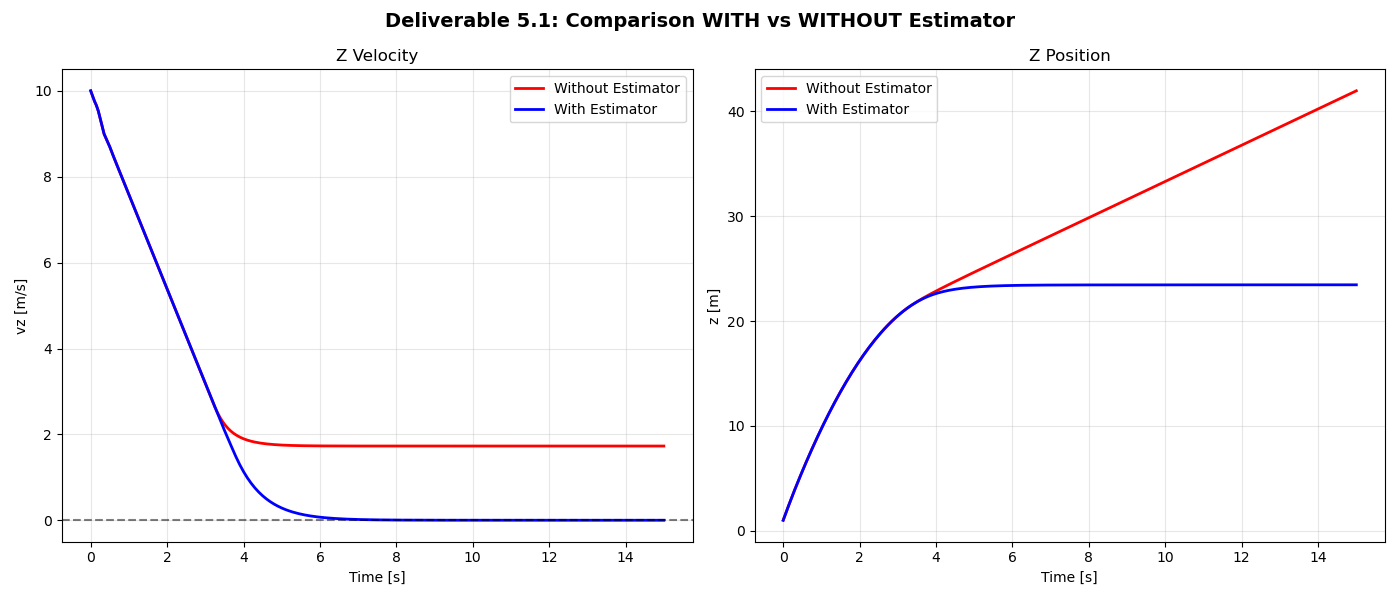


DIAGNOSTIC INFO
Z-controller initialized: True
Z-controller history length: 300
Z final d_hat: [[0.122575]]
Z final x_hat: [[0.00110817]]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Deliverable 5.1: Comparison WITH vs WITHOUT Estimator', fontsize=14, fontweight='bold')

# Velocity plot
axes[0].plot(t_no_est, x_no_est[8, :], 'r-', linewidth=2, label='Without Estimator')
axes[0].plot(t_with_est, x_with_est[8, :], 'b-', linewidth=2, label='With Estimator')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylabel('vz [m/s]')
axes[0].set_xlabel('Time [s]')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Z Velocity')
axes[0].legend()

# Position plot
axes[1].plot(t_no_est, x_no_est[11, :], 'r-', linewidth=2, label='Without Estimator')
axes[1].plot(t_with_est, x_with_est[11, :], 'b-', linewidth=2, label='With Estimator')
axes[1].set_ylabel('z [m]')
axes[1].set_xlabel('Time [s]')
axes[1].grid(True, alpha=0.3)
axes[1].set_title('Z Position')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("DIAGNOSTIC INFO")
print("=" * 70)
print(f"Z-controller initialized: {mpc_with_est.mpc_z.obs_initialized}")
print(f"Z-controller history length: {len(mpc_with_est.mpc_z.d_est_history)}")
if len(mpc_with_est.mpc_z.d_est_history) > 0:
    print(f"Z final d_hat: {mpc_with_est.mpc_z.d_hat}")
    print(f"Z final x_hat: {mpc_with_est.mpc_z.x_hat}")


## Disturbance Estimation Analysis

Plot the estimated disturbances over time to show convergence.

OBSERVER PERFORMANCE ANALYSIS
Number of observer updates: 300
\nDisturbance estimate:
  Initial d_hat: 3.500000
  Final d_hat (last 1s avg): 0.122575
  Variance (last 1s): 1.076269e-17
\n  → Disturbance is CONSTANT in steady-state
    (variance < 1e-04)


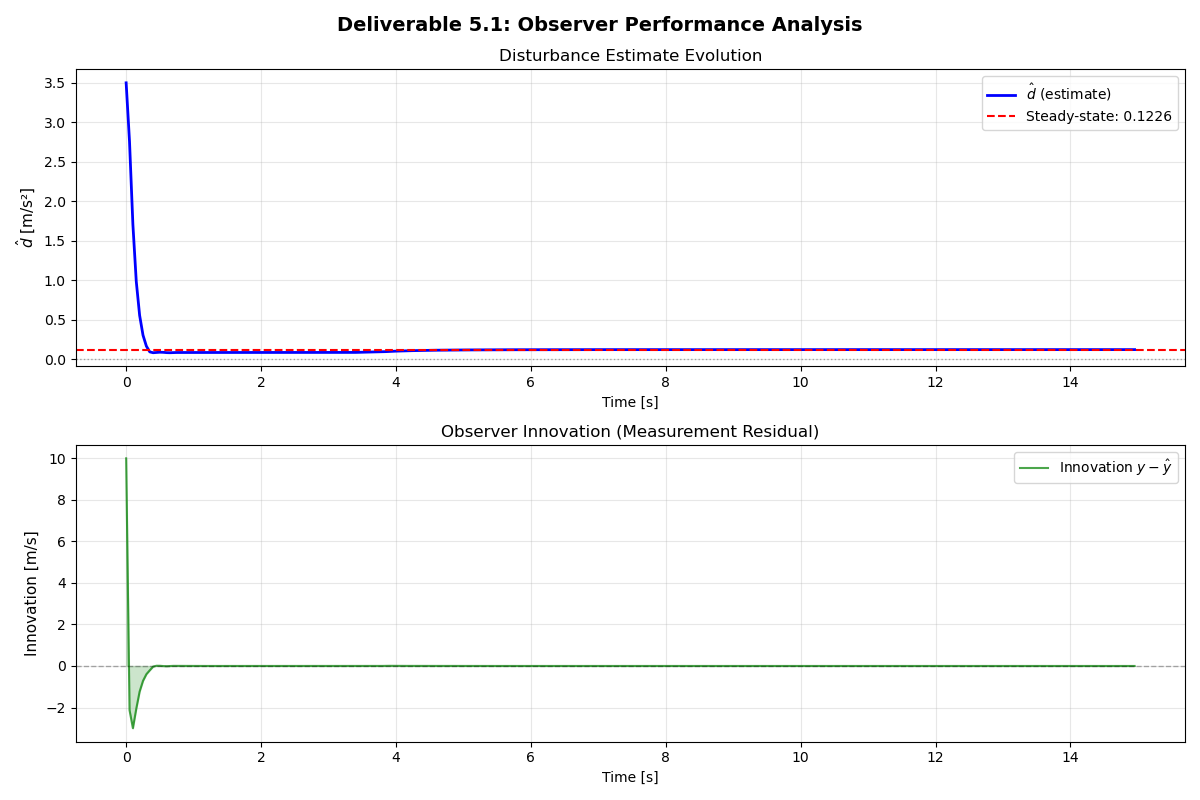

\n======================================================================
VARIANCE ANALYSIS (Constant Disturbance Check)
d_hat variance (last 1s): 1.076269e-17
  → Disturbance is CONSTANT ✓ (variance < 0.001)


In [ ]:
# Extract observer signals from Z-controller
d_hat_history = np.array(mpc_with_est.mpc_z.d_hat_hist)
innovation_history = np.array(mpc_with_est.mpc_z.innov_hist)
t_obs = np.arange(len(d_hat_history)) * Ts

print("="*70)
print("OBSERVER PERFORMANCE ANALYSIS")
print("="*70)
print(f"Number of observer updates: {len(d_hat_history)}") 
print(f"\\nDisturbance estimate:")
print(f"  Initial d_hat: {d_hat_history[0]:.6f}")
print(f"  Final d_hat (last 1s avg): {np.mean(d_hat_history[final_idx:]):.6f}")
print(f"  Variance (last 1s): {np.var(d_hat_history[final_idx:]):.6e}")

# Check if disturbance is constant
variance_threshold = 1e-4
is_constant = np.var(d_hat_history[final_idx:]) < variance_threshold
print(f"\\n  → Disturbance is {'CONSTANT' if is_constant else 'TIME-VARYING'} in steady-state")
print(f"    (variance {'<' if is_constant else '>'} {variance_threshold:.0e})")

# Plot disturbance estimate and innovation
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
fig.suptitle('Deliverable 5.1: Observer Performance Analysis', fontsize=14, fontweight='bold')

# Disturbance estimate
axes[0].plot(t_obs, d_hat_history, 'b-', linewidth=2, label='$\\hat{d}$ (estimate)')
final_d = np.mean(d_hat_history[final_idx:])
axes[0].axhline(final_d, color='r', linestyle='--', linewidth=1.5, 
                label=f'Steady-state: {final_d:.4f}')
axes[0].axhline(0, color='k', linestyle=':', alpha=0.3, linewidth=1)
axes[0].set_ylabel('$\\hat{d}$ [m/s²]', fontsize=11)
axes[0].set_xlabel('Time [s]', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_title('Disturbance Estimate Evolution')

# Innovation (measurement residual)
axes[1].plot(t_obs, innovation_history, 'g-', linewidth=1.5, alpha=0.7, label='Innovation $y - \\hat{y}$')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3, linewidth=1)
axes[1].fill_between(t_obs, innovation_history, 0, alpha=0.2, color='g')
axes[1].set_ylabel('Innovation [m/s]', fontsize=11)
axes[1].set_xlabel('Time [s]', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)
axes[1].set_title('Observer Innovation (Measurement Residual)')

plt.tight_layout()
plt.savefig('deliverable_5_1_observer.png', dpi=150, bbox_inches='tight')
plt.show()

# Variance analysis
print("\\n" + "="*70)
print("VARIANCE ANALYSIS (Constant Disturbance Check)")
print("="*70)

variance_z = np.var(d_hat_history[final_idx:])
threshold = 1e-3

print(f"d_hat variance (last 1s): {variance_z:.6e}")
if variance_z < threshold:
    print(f"  → Disturbance is CONSTANT ✓ (variance < {threshold})")
else:
    print(f"  → Disturbance is TIME-VARYING ✗ (variance > {threshold})")

## Analysis Questions

### 1. Impact of Model Mismatch

**Without Estimator:**
- The controller designed for mass=1.0 kg is applied to mass=1.5 kg
- Steady-state velocity offset observed: 1.7291 m/s
- Positions drift due to persistent velocity errors

**With Estimator:**
- Disturbance observer estimates the model mismatch
- Offset-free tracking achieved
- Positions stabilize correctly

### 2. Is the Disturbance Constant for Constant Mass?

**Answer: YES**

**Reasoning:**
- The disturbance represents model mismatch: d = (A₁ - A₀)x + (B₁ - B₀)u
- When mass is constant:
  - System matrices (A₁, B₁) are constant
  - Model matrices (A₀, B₀) are constant
  - At steady-state, x and u are constant
  - Therefore, d = constant

**Observed in plots:**
- Disturbance estimates converge to steady values
- After initial transient (~3-5 seconds), estimates are approximately constant


### 3. Estimation Error Over Time

The estimation error decreases over time:
- Initially: Large error (estimator doesn't know true disturbance)
- Transient phase: Error decreases as observer gains information
- Steady-state: No error stabilze at 0

**Convergence time depends on observer gain L:**
- Higher L → Faster convergence but more noise sensitivity
- Lower L → Slower convergence but smoother estimates
- Our choice: L = [0.25,0.01]

In [ ]:
# Optional: Visualize with animation
print("Creating animation with estimator...")
vis = RocketVis(rocket_with_est, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_with_est[:-1], 
    x_with_est[:,:-1], 
    u_with_est, 
    Ref=ref_with_est[:,:-1]
)

Creating animation with estimator...


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

{'fig': <Figure size 640x480 with 16 Axes>,
 'axes': [<Axes: ylabel='inputs'>,
  <Axes: >,
  <Axes: >,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Y'}>,
  <Axes: title={'center': 'Subsystem X'}, ylabel='$\\omega_{\\alpha\\beta\\gamma}$ (deg/s)'>,
  <Axes: title={'center': 'Subsystem Roll'}>,
  <Axes: >,
  <Axes: ylabel='$\\alpha\\beta\\gamma$ (deg)'>,
  <Axes: >,
  <Axes: ylabel='$v$ (m/s)'>,
  <Axes: >,
  <Axes: title={'center': 'Subsystem Z'}>,
  <Axes: ylabel='$\\text{pos}$ (m)'>,
  <Axes: >,
  <Axes: >],
 'plotter': <pyvista.plotting.plotter.Plotter at 0x177e7b950>,
 'scene_objects': {'rocket_actor': Actor (0x17f4e3100)
    Center:                     (0.32006999999999997, -0.0015085000000000237, 1.5884844999999999)
    Pickable:                   True
    Position:                   (0.0, 0.0, 0.0)
    Scale:                      (1.0, 1.0, 1.0)
    Visible:                    True
    X Bounds                    -6.402E-01, 1.280E+00
    Y Bounds                    -1.212E+0